## Periodontal Diease Model ##
### Predictions and performance evaluation for the test set ###

In [1]:
import os
import re
import ast
import pandas as pd
import numpy as np
import logging
import shutil
import glob
from pathlib import Path
import random
from matplotlib import pyplot as plt
from matplotlib import colormaps
import albumentations as alb
import itertools

# Scikit-learn performance metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc as calculate_auc

# PyTorch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

logger = logging.getLogger(name=__name__)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Appearance of the output plots
plt.style.use('default')
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Imports from this project
%load_ext autoreload
%autoreload 2
import periomodel
from periomodel.models.perio1 import PerioModel
from periomodel.torchdataset import DatasetFromDF, TorchDataset, augmentations
print(f'Module version:  {periomodel.__version__}')
print(f'PyTorch version: {torch.__version__}')

ModuleNotFoundError: No module named 'torchxrayvision'

In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')
# Set precision
torch.set_float32_matmul_precision('medium')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3060 Laptop GPU
CUDNN version:         90300

Device for model training/inference: cuda:0


In [3]:
def patient_image_stat(data, file_col='file', group_col='group'):
    df_n_patients = data[['PatientIDE', group_col]].\
                    drop_duplicates().\
                    groupby(by=group_col).nunique().\
                    reset_index(drop=False).\
                    rename(columns={'PatientIDE': 'n_patients'}).\
                    sort_values(by=group_col, ascending=True).\
                    reset_index(drop=True)

    df_n_images = data[[file_col, group_col]].\
                drop_duplicates().\
                groupby(by=group_col).nunique().\
                reset_index(drop=False).\
                rename(columns={file_col: 'n_images'}).\
                sort_values(by=group_col, ascending=True).\
                reset_index(drop=True)

    df_stat = df_n_patients.merge(df_n_images, on=group_col, how='inner')
    df_stat = df_stat.assign(images_per_patient=np.round(df_stat['n_images']/df_stat['n_patients']).astype(int))

    return df_stat

def im_stat(im):
    stat_dict = {'shape': im.shape,
                 'min': im.min(),
                 'max': im.max(),
                 'mean': np.round(im.mean(), decimals=3),
                 'std': np.round(im.std(), decimals=3)}
    return stat_dict

def join_tuple(tup, delim='_'):
    output_str = ''.join([str(e).replace(' ','') + delim for e in tup])
    output_str = output_str.rsplit(delim, maxsplit=1)[0]
    return output_str

def im_show(im, figsize=(3, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='gray')
    ax.set(xticks=[], yticks=[])
    return fig, ax

In [5]:
# Directories
# dcmdata
# /n/data1/hms/ccb/projects/hsdm/data/dcmdata
data_dir = os.environ.get('DATA_ROOT')
# data_dir = os.path.join(os.environ.get('DATA_ROOT'), 'dcmdata')
print(data_dir)
image_dir = os.path.join(data_dir, 'dataset', 'periodata_240415')

# Directory where we have the model log files and checkpoints for the trained model
# model_dir = os.path.join(data_dir, 'model_trained', 'periotrain_240421B')
model_dir = os.path.join(data_dir, 'model_trained', 'periotrain_240428')

# Load patient split data
patient_split_data_file = 'periodata_240415_split_ide.parquet'
df = pd.read_parquet(os.path.join(image_dir, patient_split_data_file))
display(df.head())

/app/data


,annotation_id,annotator,bbox,d1,d2,d3,d4,d5,d6,disease,id,lead_time,pos,quality,project,csv_file,image_dir,pos_quadrant,PatientIDE,annotator_name,annotation_date,annotation_update_date,file,cl2,cl3,cl4,dset
0,829,4,whole,4,2,5,4,2,4,unstable,8239,22.917,5,yes,1,project-1-at-2024-04-15-21-18-50d4fdee.csv,/app/data/image_output_230917_pred_1/single,1,a5c42982,Jennifer,2023-10-03,2023-10-03,/app/data/dataset/periodata_240415/box_a5c4298...,1,2,2,test
1,3368,2,partial,3,2,3,2,2,2,healthy,975,77.305,8,yes,1,project-1-at-2024-04-15-21-18-50d4fdee.csv,/app/data/image_output_230917_pred_1/single,1,9ca1c988,Michael,2023-10-20,2023-10-20,/app/data/dataset/periodata_240415/box_9ca1c98...,0,0,0,train
2,2218,6,whole,3,2,3,3,2,3,healthy,552,58.952,18,yes,1,project-1-at-2024-04-15-21-18-50d4fdee.csv,/app/data/image_output_230917_pred_1/single,3,f87a6c3c,Stacy,2023-10-09,2023-10-09,/app/data/dataset/periodata_240415/box_f87a6c3...,0,0,0,train
3,3135,7,whole,3,2,2,2,2,2,healthy,6784,26.122,9,yes,1,project-1-at-2024-04-15-21-18-50d4fdee.csv,/app/data/image_output_230917_pred_1/single,2,efaeb784,Maria,2023-10-18,2023-10-18,/app/data/dataset/periodata_240415/box_efaeb78...,0,0,0,val
4,2959,7,whole,3,2,4,3,2,3,stable,5001,231.491,12,yes,1,project-1-at-2024-04-15-21-18-50d4fdee.csv,/app/data/image_output_230917_pred_1/single,2,0ca8f7bf,Maria,2023-10-15,2023-10-15,/app/data/dataset/periodata_240415/box_0ca8f7b...,0,1,1,val


In [6]:
# Label assignments in data set
label_dict = {}
label_dict_inv = {}
label_col_list = ['cl2', 'cl3']
for label_col in label_col_list:
    cl_list = sorted(list(df.get(label_col).unique()))
    ds_list = [tuple(df.loc[df[label_col]==cl, 'disease'].unique()) for cl in cl_list]
    label_cl_dict = dict(zip(cl_list, ds_list))
    label_dict.update({label_col: label_cl_dict})
    
    ds_list_inv = sorted(list(df.get('disease').unique()))
    cl_list_inv = [int(df.loc[df['disease'] == disease, label_col].values[0]) for disease in ds_list_inv]
    label_cl_dict_inv = dict(zip(ds_list_inv, cl_list_inv))
    label_dict_inv.update({label_col: label_cl_dict_inv})
display(label_dict)
print()
display(label_dict_inv)

{'cl2': {0: ('healthy', 'stable'), 1: ('unstable', 'very unstable')},
 'cl3': {0: ('healthy',), 1: ('stable',), 2: ('unstable', 'very unstable')}}

{'cl2': {'healthy': 0, 'stable': 0, 'unstable': 1, 'very unstable': 1},
 'cl3': {'healthy': 0, 'stable': 1, 'unstable': 2, 'very unstable': 2}}

### Training, validation and testing data ###

In [7]:
# Image data used for these models
dset_list = sorted(list(df.get('dset').unique()))
for dset in dset_list:
    df_dset = df.loc[df['dset'] == dset]
    dset_n_images = len(df_dset['file'].unique())
    print(f'{dset.upper()}: {dset_n_images} IMAGES')
    disease_stat = patient_image_stat(df_dset, file_col='file', group_col='annotator_name')
    display(disease_stat)
    for label_col in ['cl3', 'cl2']:
        cl_stat = patient_image_stat(df_dset, file_col='file', group_col=label_col)
        print(f'{dset.upper()} IMAGES FOR {label_col.upper()} MODEL')
        display(cl_stat)

TEST: 614 IMAGES


,annotator_name,n_patients,n_images,images_per_patient
0,Jennifer,25,468,19
1,Maria,19,89,5
2,Michael,18,35,2
3,Stacy,12,22,2


TEST IMAGES FOR CL3 MODEL


,cl3,n_patients,n_images,images_per_patient
0,0,20,120,6
1,1,25,283,11
2,2,16,211,13


TEST IMAGES FOR CL2 MODEL


,cl2,n_patients,n_images,images_per_patient
0,0,25,403,16
1,1,16,211,13


TRAIN: 2869 IMAGES


,annotator_name,n_patients,n_images,images_per_patient
0,Jennifer,118,2098,18
1,Maria,89,487,5
2,Michael,70,167,2
3,Stacy,63,117,2


TRAIN IMAGES FOR CL3 MODEL


,cl3,n_patients,n_images,images_per_patient
0,0,75,700,9
1,1,111,1157,10
2,2,87,1012,12


TRAIN IMAGES FOR CL2 MODEL


,cl2,n_patients,n_images,images_per_patient
0,0,112,1857,17
1,1,87,1012,12


VAL: 366 IMAGES


,annotator_name,n_patients,n_images,images_per_patient
0,Jennifer,15,289,19
1,Maria,10,52,5
2,Michael,8,16,2
3,Stacy,5,9,2


VAL IMAGES FOR CL3 MODEL


,cl3,n_patients,n_images,images_per_patient
0,0,10,65,6
1,1,15,174,12
2,2,10,127,13


VAL IMAGES FOR CL2 MODEL


,cl2,n_patients,n_images,images_per_patient
0,0,15,239,16
1,1,10,127,13


In [8]:
# Model parameter
model_name = 'periocl3_128'
model_version_number = 1
model_version = f'version_{model_version_number}'
label_col = 'cl3'
labels = label_dict.get(label_col)

# Disease labels
disease_labels = label_dict.get(label_col)

max_im_size = 2500
im_size = 512
batch_size = 6

checkpoint_dir = os.path.join(model_dir, model_name, model_version, 'checkpoints')
log_file = os.path.join(model_dir, model_name, model_version, 'log', 'train.log')
output_dir = os.path.join(model_dir, model_name, model_version, 'output')
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(labels)

{0: ('healthy',), 1: ('stable',), 2: ('unstable', 'very unstable')}


In [9]:
# Open log file for this model
# https://stackoverflow.com/questions/39807724/extract-python-dictionary-from-string
print(output_dir)
with open(log_file, 'r') as fl:
    log = fl.read()
params = ast.literal_eval(re.search('({.+})', log).group(0))
display(params)

im_mean = params.get('im_mean')
im_std = params.get('im_std')
gray = params.get('gray')

/app/data/model_trained/periotrain_240428/periocl3_128/version_1/output


{'max_epochs': 3000,
 'batch_size': 128,
 'augment': 'augment_1',
 'dataset': 'periodata_240415',
 'learning_rate': 0.0002,
 'max_im_size': 2500,
 'num_workers': 8,
 'im_size': 512,
 'im_mean': 0,
 'im_std': 1,
 'hist_eq': True,
 'gray': True,
 'n_hidden': 128,
 'model': 'xrv',
 'model_name': 'periocl3_128',
 'model_version': 1,
 'checkpoint_every_n_epoch': 100,
 'checkpoint_monitor': 'val_loss',
 'check_val_every_n_epoch': 2,
 'save_top_k_epochs': 20,
 'file_col': 'file',
 'label_col': 'cl3',
 'comment': 'validation',
 'date': 240428,
 'model_dir': '/n/scratch/users/a/aaw10/dcmdata/model',
 'checkpoint_dir': '/n/scratch/users/a/aaw10/dcmdata/model/periocl3_128/version_1/checkpoints',
 'label_list': [0, 1, 2],
 'disease_list': [['healthy'], ['stable'], ['unstable', 'very unstable']],
 'data_file': '/n/scratch/users/a/aaw10/dcmdata/dataset/periodata_240415/periodata_240415_split_ide.parquet'}

In [10]:
# Data sets
train_set = set(df.loc[df.get('dset') == 'train'].index)
val_set = set(df.loc[df.get('dset') == 'val'].index)
test_set = set(df.loc[df.get('dset') == 'test'].index)
print(train_set.intersection(val_set))
print(train_set.intersection(test_set))
print(val_set.intersection(test_set))

# Test set
test_df = df.loc[df.get('dset') == 'test'].reset_index(drop=True)
display(test_df.head(2))
print(test_df.shape)

set()
set()
set()


,annotation_id,annotator,bbox,d1,d2,d3,d4,d5,d6,disease,id,lead_time,pos,quality,project,csv_file,image_dir,pos_quadrant,PatientIDE,annotator_name,annotation_date,annotation_update_date,file,cl2,cl3,cl4,dset
0,829,4,whole,4,2,5,4,2,4,unstable,8239,22.917,5,yes,1,project-1-at-2024-04-15-21-18-50d4fdee.csv,/app/data/image_output_230917_pred_1/single,1,a5c42982,Jennifer,2023-10-03,2023-10-03,/app/data/dataset/periodata_240415/box_a5c4298...,1,2,2,test
1,1758,4,whole,3,3,4,3,3,4,stable,1600,21.935,18,yes,1,project-1-at-2024-04-15-21-18-50d4fdee.csv,/app/data/image_output_230917_pred_1/single,3,956a3988,Jennifer,2023-10-07,2023-10-07,/app/data/dataset/periodata_240415/box_956a398...,0,1,1,test


(614, 27)


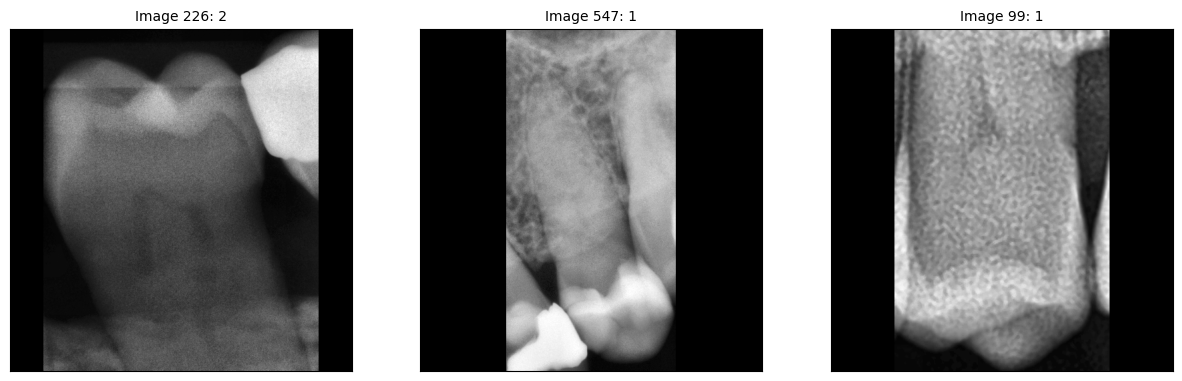

In [11]:
# Create a data set from the data frame
test_transform = augmentations(im_size=im_size, 
                               image_mean=im_mean, 
                               image_std=im_std,
                               augment=None)

test_dataset = DatasetFromDF(data=test_df,
                             file_col='file',
                             label_col=label_col,
                             max_im_size=max_im_size,
                             transform=test_transform,
                             hist_eq=True,
                             gray=gray,
                             validate=True)

dl = DataLoader(dataset=test_dataset,
                batch_size=batch_size,
                num_workers=0,
                shuffle=False)

# Show some test images
show_n_images = 3
image_idx_list = np.random.randint(len(test_dataset), size=show_n_images) 
image_list = [torch.squeeze(test_dataset[idx][0]).numpy() for idx in image_idx_list]
label_list = [test_dataset[idx][1].numpy() for idx in image_idx_list]
fig, ax = plt.subplots(nrows=1, ncols=show_n_images, figsize=(15, 5))
for i, im in enumerate(image_list):
    if gray:
        ax[i].imshow(im, cmap='gray')
    else:
        im = np.transpose(im, (1, 2, 0))
        ax[i].imshow(im)
    ax[i].set(xticks=[], yticks=[])
    ax[i].set_title(f'Image {image_idx_list[i]}: {label_list[i]}')
plt.show()

In [12]:
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, f'perio-epoch=*.ckpt'))
checkpoint_names = [os.path.basename(file) for file in checkpoint_files]
epoch_list = [int(os.path.splitext(name)[0].split('=', maxsplit=1)[-1]) + 1 for name in checkpoint_names]

chkdf = pd.DataFrame({'epoch': epoch_list,
                      'checkpoint': checkpoint_names,
                      'checkpoint_file': checkpoint_files})

chkdf = chkdf.assign(model_name=model_name,
                     model_version=model_version_number,
                     logfile=log_file).sort_values(by='epoch', ascending=True)
                     
display(chkdf.head(2))

# Pick a checkpoint and load the model
epoch_list = sorted(list(chkdf.get('epoch').unique()))
print(epoch_list)

,epoch,checkpoint,checkpoint_file,model_name,model_version,logfile
9,1100,perio-epoch=1099.ckpt,/app/data/model_trained/periotrain_240428/peri...,periocl3_128,1,/app/data/model_trained/periotrain_240428/peri...
10,1200,perio-epoch=1199.ckpt,/app/data/model_trained/periotrain_240428/peri...,periocl3_128,1,/app/data/model_trained/periotrain_240428/peri...


[1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]


### Run model predictions on testset ###

In [13]:
# Check if the predictions are already there.
predictions_file_name = f'predictions_{model_name}_{model_version_number}.parquet'
predictions_file = os.path.join(output_dir, predictions_file_name)

if not os.path.exists(predictions_file):
    pred_epoch_list = []
    for e, epoch in enumerate(epoch_list):
        print(f'Running model for checkpoint {e + 1}/{len(epoch_list)}')
        checkpoint_file = chkdf.loc[chkdf.get('epoch') == epoch, 'checkpoint_file'].values[0]
        
        perio_model = PerioModel.load_from_checkpoint(checkpoint_file,
                                                      test_set=test_dataset,
                                                      train_set=None,
                                                      val_set=None,
                                                      batch_size=batch_size,
                                                      num_workers=1)
        sm = nn.Softmax(dim=1)
        # Predict on the test set
        pred_df_batch_list = []
        for image_batch, label_batch in dl:
            pred_df_batch = pd.DataFrame(sm(perio_model(image_batch.cuda())).detach().cpu().numpy())
            pred_df_batch.columns = [f'prob_{cl}' for cl in pred_df_batch.columns]
            pred_df_batch = pred_df_batch.assign(true_cl=list(label_batch.detach().numpy()))
            pred_df_batch_list.append(pred_df_batch)
        pred_df = pd.concat(pred_df_batch_list, axis=0, ignore_index=True)
        pred_df = pred_df.assign(disease=test_df['disease'].values,
                                 PatientIDE=test_df['PatientIDE'].values,
                                 file=test_df['file'].values,
                                 epoch=epoch,
                                 checkpoint=os.path.basename(checkpoint_file),
                                 model=model_name,
                                 version=model_version_number)
        pred_epoch_list.append(pred_df)
    # Combining all of the predictions in one data frame
    pred = pd.concat(pred_epoch_list, axis=0, ignore_index=True)
    pred.to_parquet(predictions_file)
    print(f'Saved predictions: {predictions_file}')
else:
    print(f'Loading predictions from "{predictions_file}"')
    pred = pd.read_parquet(predictions_file)

display(pred.head())
print(pred.shape)

Loading predictions from "/app/data/model_trained/periotrain_240428/periocl3_128/version_1/output/predictions_periocl3_128_1.parquet"


,prob_0,prob_1,prob_2,true_cl,disease,PatientIDE,file,epoch,checkpoint,model,version
0,0.337813,0.412711,0.249476,2,unstable,a5c42982,/app/data/dataset/periodata_240415/box_a5c4298...,1100,perio-epoch=1099.ckpt,periocl3_128,1
1,0.319927,0.464736,0.215337,1,stable,956a3988,/app/data/dataset/periodata_240415/box_956a398...,1100,perio-epoch=1099.ckpt,periocl3_128,1
2,0.048973,0.765152,0.185875,2,unstable,037914b7,/app/data/dataset/periodata_240415/box_037914b...,1100,perio-epoch=1099.ckpt,periocl3_128,1
3,0.018077,0.174813,0.807109,2,very unstable,c0b47799,/app/data/dataset/periodata_240415/box_c0b4779...,1100,perio-epoch=1099.ckpt,periocl3_128,1
4,0.301821,0.319762,0.378417,1,stable,2cfc437a,/app/data/dataset/periodata_240415/box_2cfc437...,1100,perio-epoch=1099.ckpt,periocl3_128,1


(12280, 11)


### Binary test performance ###
Evaluate the models as binary classification task

In [14]:
def flatten(xss):
    """
    Args:
        xss (List[List]): List of lists to be flattened.
    Returns:
        List: Flattened list.
    """
    return [x for xs in xss for x in xs]

def list_combinations(input_list):
    """
    Args:
        input_list: A list of elements from which combinations are to be generated.
    Returns:
        output_list: A list of all possible combinations of elements from the input_list.
    """
    n = len(input_list)
    if n > 1:
        output_list = flatten([list(itertools.combinations(input_list, i)) for i in range(1, n + 1)])
    else:
        output_list = [input_list]
    return output_list

def disease_comparisons(positive_class, disease_dict):
    """
    Args:
        positive_class: The disease class for which to compare diseases.
        disease_dict: A dictionary containing disease classes as keys and their corresponding disease labels as values.
    Returns:
        A dictionary containing the positive disease cases and negative disease cases.
    """
    # disease dict {class: disease label}
    cl_list = disease_dict.keys()
    positive_disease_cases = list_combinations(disease_dict.get(positive_class))
    negative_disease_cases = list_combinations(flatten([disease_dict.get(cl) for cl in cl_list if cl != positive_class]))
    output_dict = {'positive_cases': positive_disease_cases, 
                   'negative_cases': negative_disease_cases}
    return output_dict

def join_str_list(str_list, sep='_'):
    return sep.join(str_list).replace(' ', '')

def f1_scores(pres, recs, thresholds):
    """
    Args:
        pres: A list of precision values calculated using the precision_recall_curve function.
        recs: A list of recall values calculated using the precision_recall_curve function.
        thresholds: A list of threshold values used in the precision_recall_curve function.
    Returns:
        f1_df: A pandas DataFrame containing F1 scores calculated for each threshold.
    """
    # Use the ouput of the precision_recall_curve function as the input
    # F1 scores for all thresholds
    f1_dict = {'precision': pres[:-1],
               'recall': recs[:-1],
               'thresh': thresholds}
    f1_df = pd.DataFrame(f1_dict)
    f1_df = f1_df.assign(f1=2 * (f1_df['precision'] * f1_df['recall']) / (f1_df['precision'] + f1_df['recall']))
    f1_df = f1_df.dropna(subset='f1')
    return f1_df

# plot the ROC curve
def plot_roc(fpr, tpr, label='roc', ax=None, color='b'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=False)
    ax.plot(fpr, tpr, color=color, linewidth=1.5, alpha=1.0, label=label)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0, 1.2, 0.2),
           xlabel='False positive rate (1 - specificity)', ylabel='True positive rate (sensitivity)')
    ax.plot([0.05, 0.95], [0.05, 0.95], 
            transform=ax.transAxes, color='k', linewidth=2, alpha=0.8, linestyle=':')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(0, 1.1), loc='upper left', fontsize=SMALL_SIZE)
    return ax

# plot the PR curve
def plot_pr(rec, pre, ns_pre=0.0, label='pr', ax=None, color='b'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=False)
    ax.plot(rec, pre, color=color, linewidth=1.5, alpha=1.0, label=label)
    ax.axhline(y=ns_pre, color='k', linewidth=2, alpha=0.8, linestyle=':')
    ax.set(xlim=[-0.05, 1.05], ylim=[0.0, 1.05],
           xticks=np.arange(0.0, 1.2, 0.2), yticks=np.arange(0.0, 1.2, 0.2),
           xlabel='True positive rate (sensitivity)', ylabel='Precision')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(0, 1.1), loc='upper left', fontsize=SMALL_SIZE)
    return ax


def find_list_index(input_list, input_value):
    """ find the index of the value that is closest to the input value """
    idx = list(input_list).index(min(input_list, key=lambda x:abs(x - input_value)))
    return idx

In [15]:
# Create dataset permutations
pos_cl_list = sorted(list(labels.keys()))
ds_list = [labels.get(pos) for pos in pos_cl_list]
pos_cl = 2
pos_disease_list_cases = list_combinations(labels.get(pos_cl))
neg_disease_list_cases = list_combinations(flatten([labels.get(cl) for cl in pos_cl_list if cl != pos_cl]))

cases_dict = disease_comparisons(positive_class=pos_cl, disease_dict=labels)
display(cases_dict)

{'positive_cases': [('unstable',),
  ('very unstable',),
  ('unstable', 'very unstable')],
 'negative_cases': [('healthy',), ('stable',), ('healthy', 'stable')]}

In [16]:
def performance_metrics(y_true, y_pred, test_pred_stat, sensitivity=0.7):
    """
    Calculates various performance metrics for classification models.
    Args:
        y_true: 1-dimensional array-like or list of true labels.
        y_pred: 1-dimensional array-like or list of predicted probabilities.
    Returns:
        Tuple containing two dictionaries:
            - metrics_dict: Contains calculated performance metrics.
            - roc_dict: Contains ROC curve data.
    """
    # Calculate performance metrics
    # ROC and AUC for ROC
    fpr, tpr, roc_thresholds = roc_curve(y_true=y_true, y_score=y_pred)
    auc = np.round(roc_auc_score(y_true=y_true, y_score=y_pred), decimals=decimals)
    roc_idx = find_list_index(input_list=tpr, input_value=sensitivity)
    # ROC values at defined sensitivity
    fpr_s = fpr[roc_idx]
    tpr_s = tpr[roc_idx]
    roc_thresholds_s = roc_thresholds[roc_idx]
    # For this threshold, calculate the confusion matrix
    y_pred_cl = np.array([1 if pred >= roc_thresholds_s else 0 for pred in y_pred])
    conf = confusion_matrix(y_true=y_true, y_pred=y_pred_cl, normalize=None)
    TN = conf[0, 0]
    FN = conf[1, 0]
    TP = conf[1, 1]
    FP = conf[0, 1]
    n_actual_pos = len(y_true[y_true == 1])
    n_actual_neg = len(y_true[y_true == 0])
    n_pred_pos = len(y_pred_cl[y_pred_cl == 1])
    n_pred_neg = len(y_pred_cl[y_pred_cl == 0])
     
    # P-R and AUC for P-R
    pre, rec, pre_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    # Calculate the precision when we set all predictions positive (threshold=0)
    min_precision = np.round(len(y_true[y_true==1]) / len(y_true), decimals=decimals)
    auc_pre = np.round(calculate_auc(x=rec, y=pre), decimals=decimals)
    # P-R values at defined sensitivity
    pre_idx = find_list_index(input_list=rec, input_value=sensitivity)
    pre_s = pre[pre_idx]
    # Is this model useful
    useful_model = 1 if (pre_s > min_precision) & (auc > 0.5) else 0
    rec_s = rec[pre_idx]
    pre_thresholds_s = pre_thresholds[pre_idx]
    f1_s = 2 * pre_s * rec_s / (pre_s + rec_s)
    f1_df = f1_scores(pres=pre, recs=rec, thresholds=pre_thresholds)
    
    # Get precision, recall at maximum F1
    f1_max = dict(f1_df.loc[f1_df['f1'] == f1_df['f1'].max()].iloc[0])
    precision_f1_max = np.round(f1_max.get('precision'), decimals=decimals)
    recall_f1_max = np.round(f1_max.get('recall'), decimals=decimals)
    thresh_f1_max = np.round(f1_max.get('thresh'), decimals=decimals)
    f1score_f1_max = np.round(f1_max.get('f1'), decimals=decimals)
    
    # Collect the results
    metrics_dict = {'roc_auc': auc,
                    'pr_auc': auc_pre,
                    'min_precision': min_precision,
                    'max_f1_thresh': thresh_f1_max,
                    'max_f1_score': f1score_f1_max,
                    'TP': TP,
                    'TN': TN,
                    'FP': FP,
                    'FN': FN,
                    'n_actual_pos': n_actual_pos,
                    'n_actual_neg': n_actual_neg,
                    'n_pred_pos': n_pred_pos,
                    'n_pred_neg': n_pred_neg,
                    'precision': pre_s,
                    'useful': useful_model,
                    'recall': rec_s,
                    'TPR': tpr_s,
                    'FPR': fpr_s,
                    'FDR': 1 - pre_s,
                    'F1': f1_s,
                    'threshold': pre_thresholds_s,
                    'n_patients_pos': test_pred_stat.loc[test_pred_stat['true'] == 1, 'n_patients'].values[0],
                    'n_patients_neg': test_pred_stat.loc[test_pred_stat['true'] == 0, 'n_patients'].values[0],
                    'n_images_pos': test_pred_stat.loc[test_pred_stat['true'] == 1, 'n_images'].values[0],
                    'n_images_neg': test_pred_stat.loc[test_pred_stat['true'] == 0, 'n_images'].values[0]}
    
    roc_dict = {'fpr' :fpr,
                'tpr' :tpr,
                'roc_thresholds': roc_thresholds,
                'pre': pre,
                'rec': rec,
                'pre_thresholds': pre_thresholds}

    return metrics_dict, roc_dict

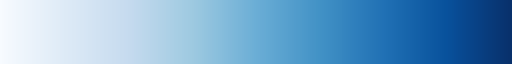

In [17]:
# Parameters
figsize = (6, 6)
decimals = 3
recall_interval = [0.6, 0.7]
cmap = colormaps.get('Blues')
display(cmap)
# Generate a list of colors
n_colors = 10
colors = cmap(np.linspace(0.5, 1, n_colors))

Case number: 1
Positive disease classes: healthy
Negative disease classes: stable


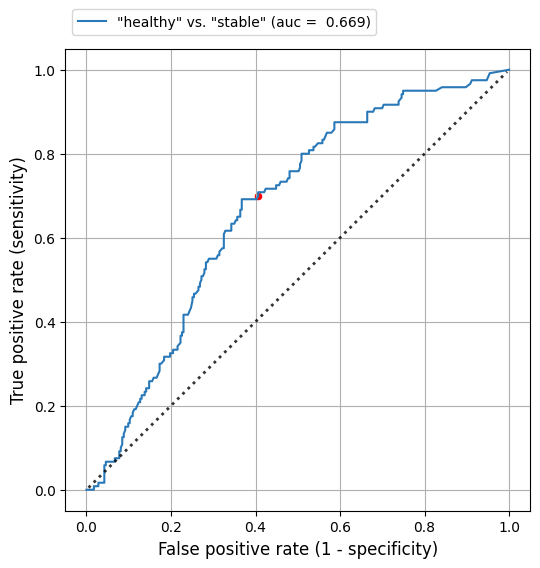

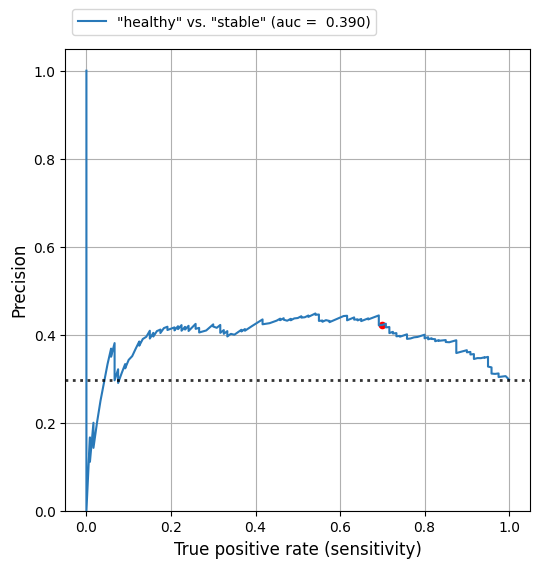

case                                               1
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                               healthy
negative_class                                stable
image_name                       1_healthy_vs_stable
roc_auc                                        0.669
pr_auc                                          0.39
min_precision                                  0.298
max_f1_thresh                                  0.216
max_f1_score                                   0.541
TP                                                84
TN                                               168
FP                                               115
FN                                                36
n_actual_pos                                     120
n_actual_neg                                     283
n_pred_pos                                    

Case number: 2
Positive disease classes: healthy
Negative disease classes: unstable


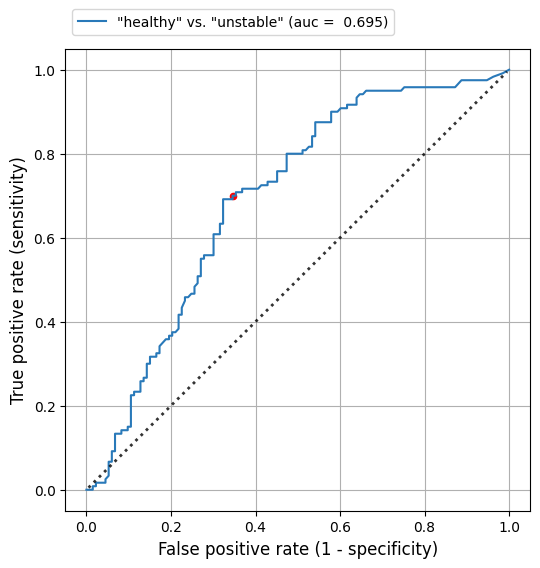

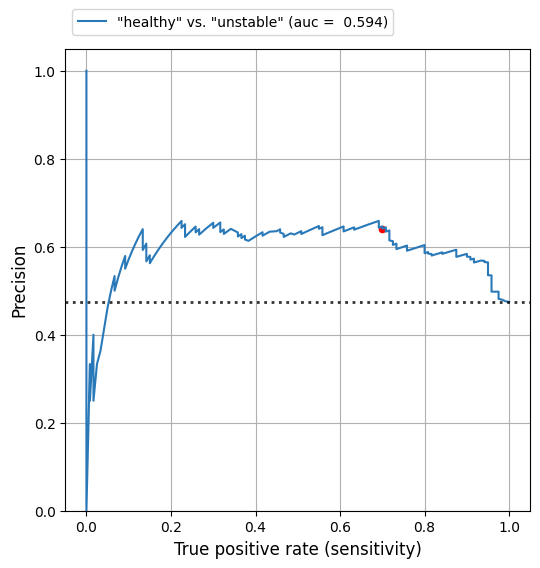

case                                               2
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                               healthy
negative_class                              unstable
image_name                     2_healthy_vs_unstable
roc_auc                                        0.695
pr_auc                                         0.594
min_precision                                  0.474
max_f1_thresh                                  0.042
max_f1_score                                   0.708
TP                                                84
TN                                                87
FP                                                46
FN                                                36
n_actual_pos                                     120
n_actual_neg                                     133
n_pred_pos                                    

Case number: 3
Positive disease classes: healthy
Negative disease classes: veryunstable


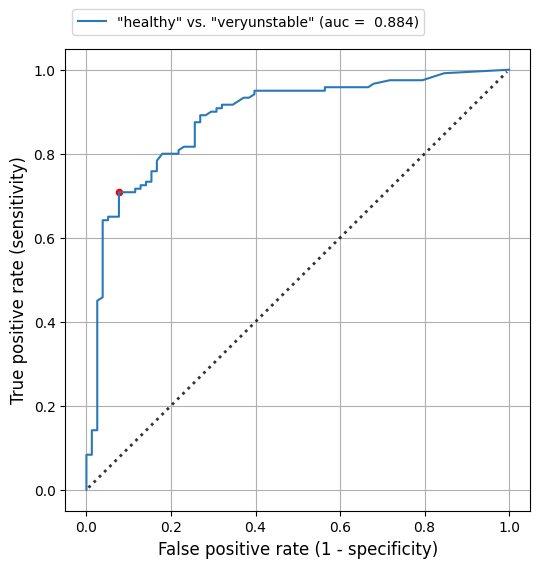

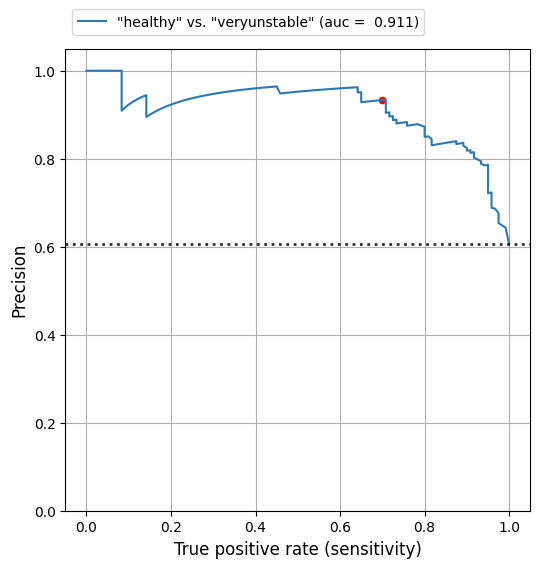

case                                               3
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                               healthy
negative_class                          veryunstable
image_name                 3_healthy_vs_veryunstable
roc_auc                                        0.884
pr_auc                                         0.911
min_precision                                  0.606
max_f1_thresh                                   0.08
max_f1_score                                   0.863
TP                                                85
TN                                                72
FP                                                 6
FN                                                35
n_actual_pos                                     120
n_actual_neg                                      78
n_pred_pos                                    

Case number: 4
Positive disease classes: healthy
Negative disease classes: stable+unstable


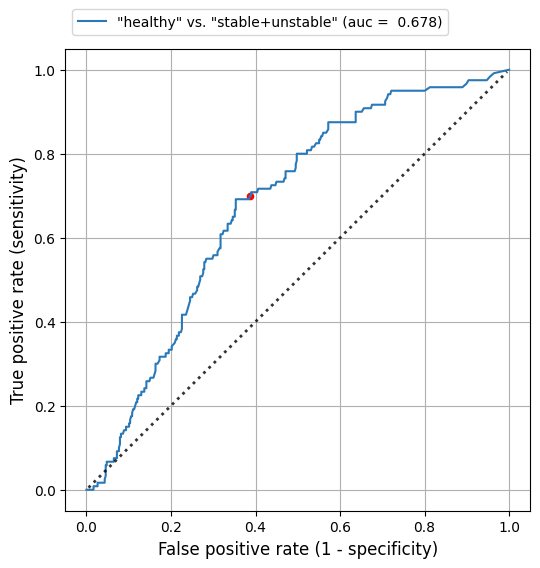

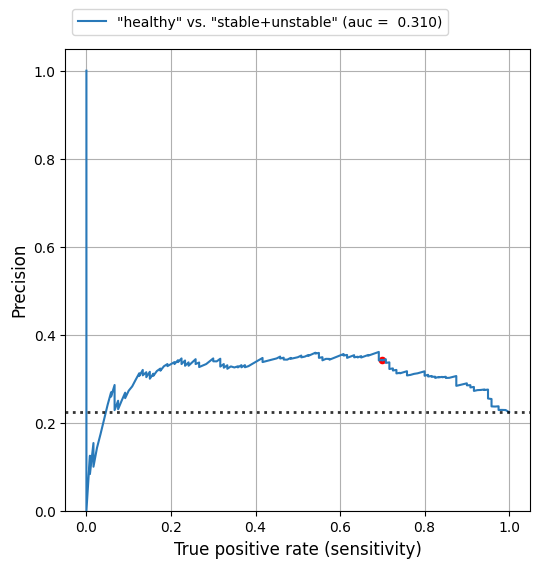

case                                               4
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                               healthy
negative_class                       stable_unstable
image_name              4_healthy_vs_stable_unstable
roc_auc                                        0.678
pr_auc                                          0.31
min_precision                                  0.224
max_f1_thresh                                  0.216
max_f1_score                                   0.474
TP                                                84
TN                                               255
FP                                               161
FN                                                36
n_actual_pos                                     120
n_actual_neg                                     416
n_pred_pos                                    

Case number: 5
Positive disease classes: healthy
Negative disease classes: stable+veryunstable


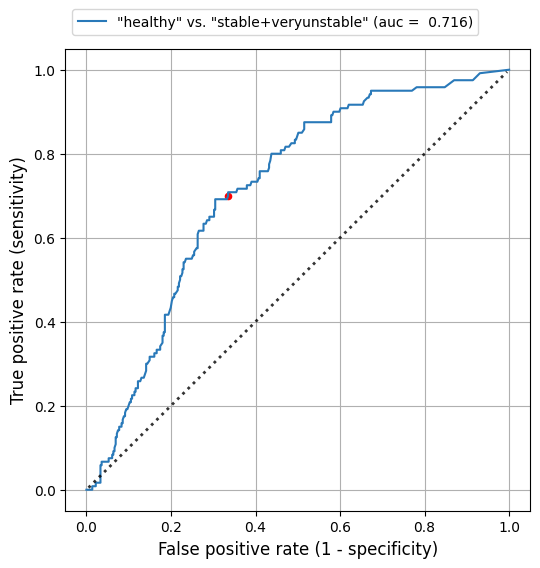

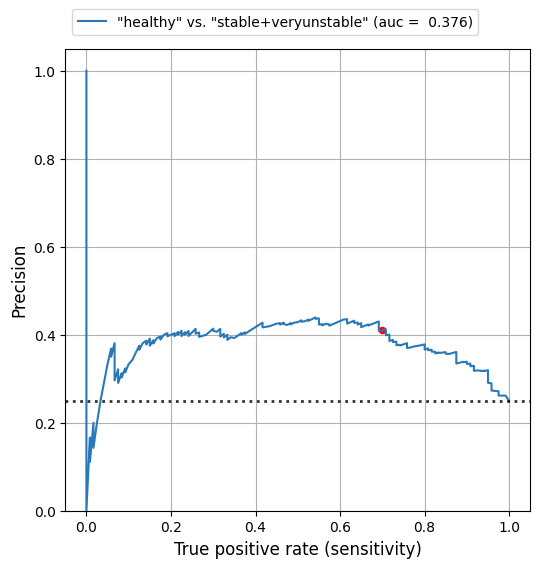

case                                               5
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                               healthy
negative_class                   stable_veryunstable
image_name          5_healthy_vs_stable_veryunstable
roc_auc                                        0.716
pr_auc                                         0.376
min_precision                                  0.249
max_f1_thresh                                  0.216
max_f1_score                                    0.53
TP                                                84
TN                                               240
FP                                               121
FN                                                36
n_actual_pos                                     120
n_actual_neg                                     361
n_pred_pos                                    

Case number: 6
Positive disease classes: healthy
Negative disease classes: unstable+veryunstable


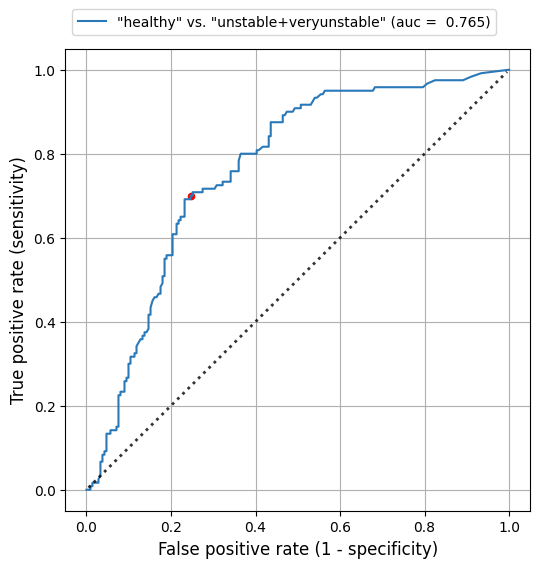

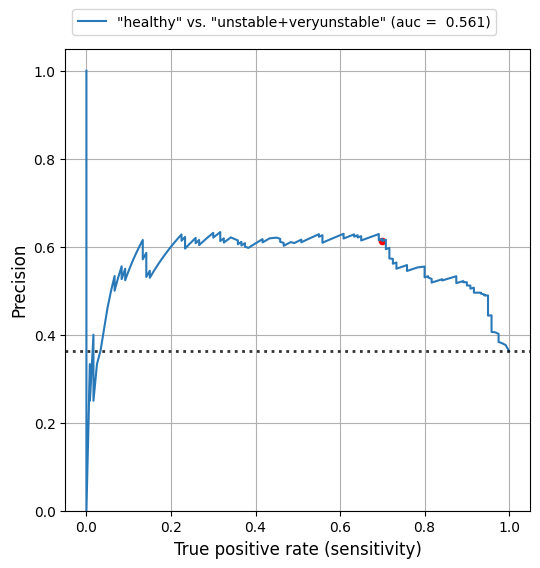

case                                               6
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                               healthy
negative_class                 unstable_veryunstable
image_name        6_healthy_vs_unstable_veryunstable
roc_auc                                        0.765
pr_auc                                         0.561
min_precision                                  0.363
max_f1_thresh                                  0.101
max_f1_score                                   0.662
TP                                                84
TN                                               159
FP                                                52
FN                                                36
n_actual_pos                                     120
n_actual_neg                                     211
n_pred_pos                                    

Case number: 7
Positive disease classes: healthy
Negative disease classes: stable+unstable+veryunstable


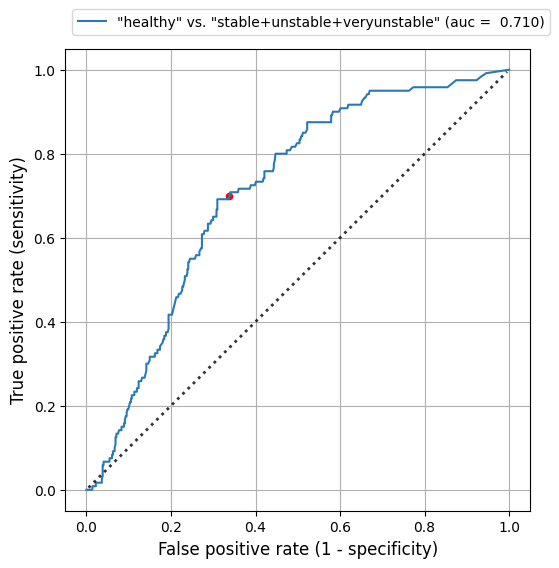

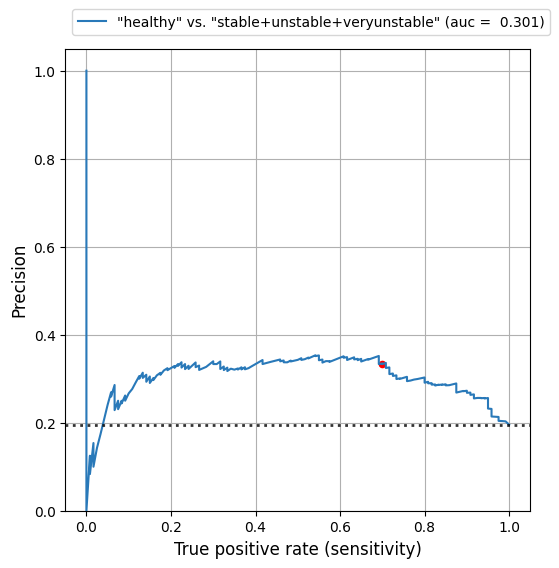

case                                                      7
model                                          periocl3_128
version                                                   1
testdata                 periodata_240415_split_ide.parquet
positive_class                                      healthy
negative_class                 stable_unstable_veryunstable
image_name        7_healthy_vs_stable_unstable_veryunstable
roc_auc                                                0.71
pr_auc                                                0.301
min_precision                                         0.195
max_f1_thresh                                         0.216
max_f1_score                                          0.466
TP                                                       84
TN                                                      327
FP                                                      167
FN                                                       36
n_actual_pos                            

Case number: 8
Positive disease classes: stable
Negative disease classes: healthy


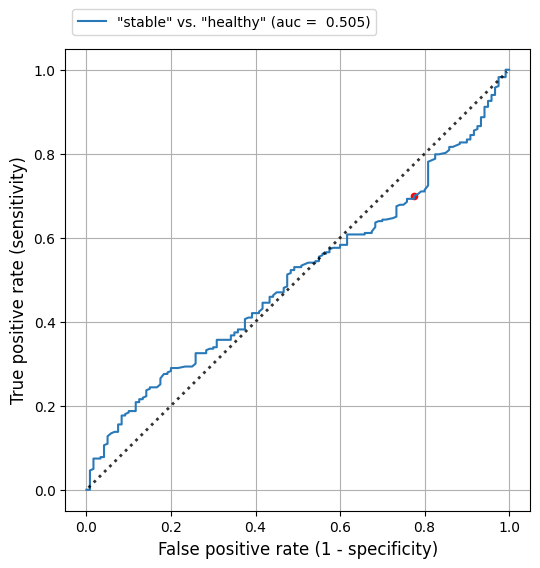

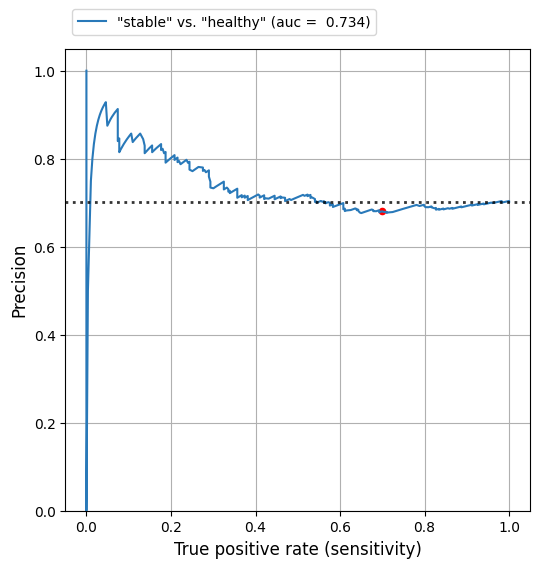

case                                               8
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                                stable
negative_class                               healthy
image_name                       8_stable_vs_healthy
roc_auc                                        0.505
pr_auc                                         0.734
min_precision                                  0.702
max_f1_thresh                                  0.022
max_f1_score                                   0.826
TP                                               198
TN                                                27
FP                                                93
FN                                                85
n_actual_pos                                     283
n_actual_neg                                     120
n_pred_pos                                    

Case number: 9
Positive disease classes: stable
Negative disease classes: unstable


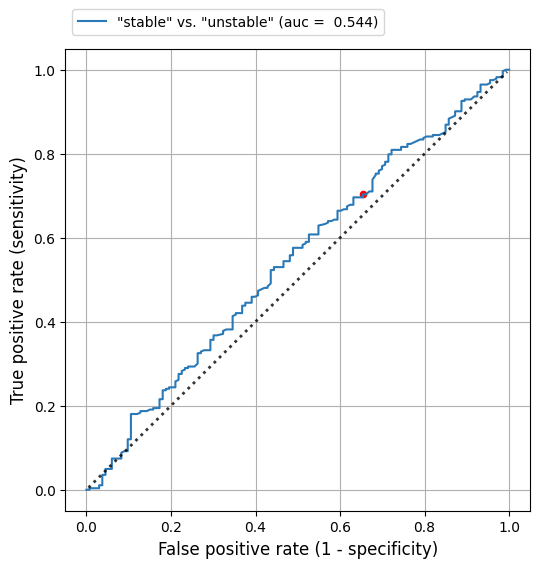

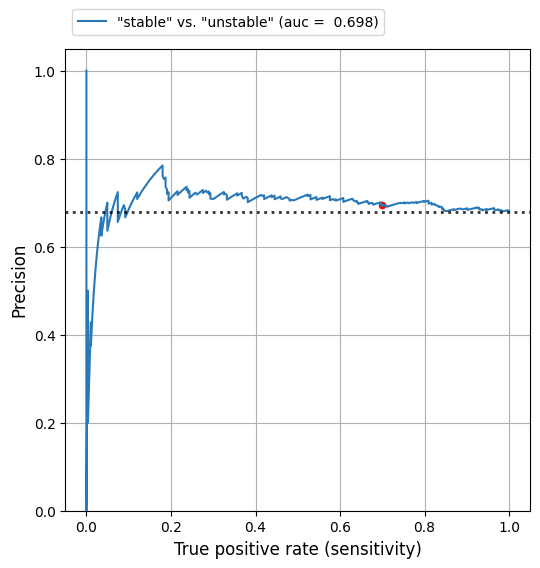

case                                               9
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                                stable
negative_class                              unstable
image_name                      9_stable_vs_unstable
roc_auc                                        0.544
pr_auc                                         0.698
min_precision                                   0.68
max_f1_thresh                                  0.022
max_f1_score                                   0.811
TP                                               199
TN                                                46
FP                                                87
FN                                                84
n_actual_pos                                     283
n_actual_neg                                     133
n_pred_pos                                    

Case number: 10
Positive disease classes: stable
Negative disease classes: veryunstable


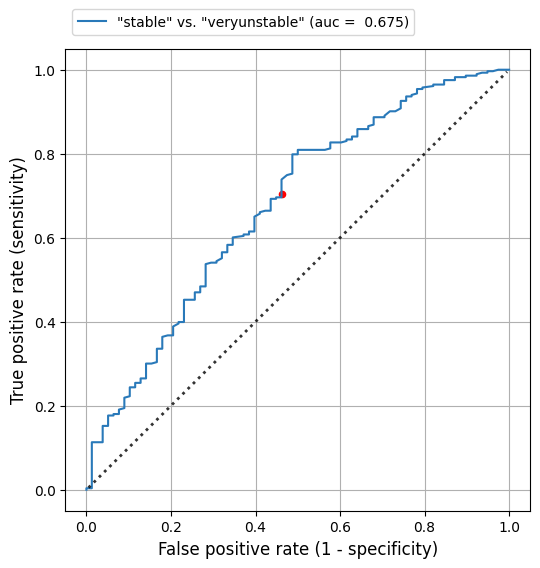

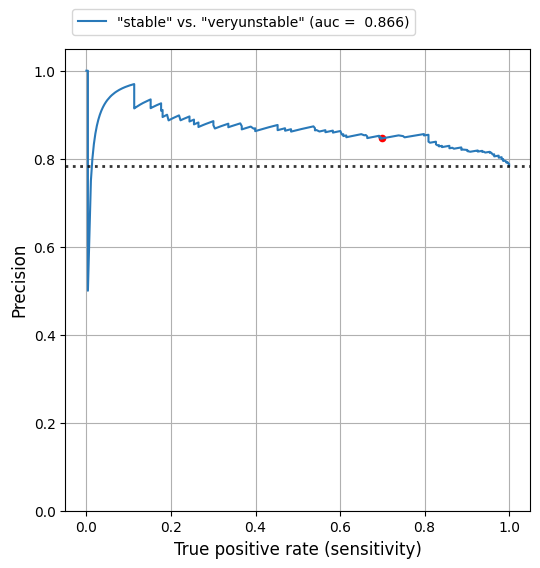

case                                              10
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                                stable
negative_class                          veryunstable
image_name                 10_stable_vs_veryunstable
roc_auc                                        0.675
pr_auc                                         0.866
min_precision                                  0.784
max_f1_thresh                                  0.066
max_f1_score                                   0.884
TP                                               199
TN                                                42
FP                                                36
FN                                                84
n_actual_pos                                     283
n_actual_neg                                      78
n_pred_pos                                    

Case number: 11
Positive disease classes: stable
Negative disease classes: healthy+unstable


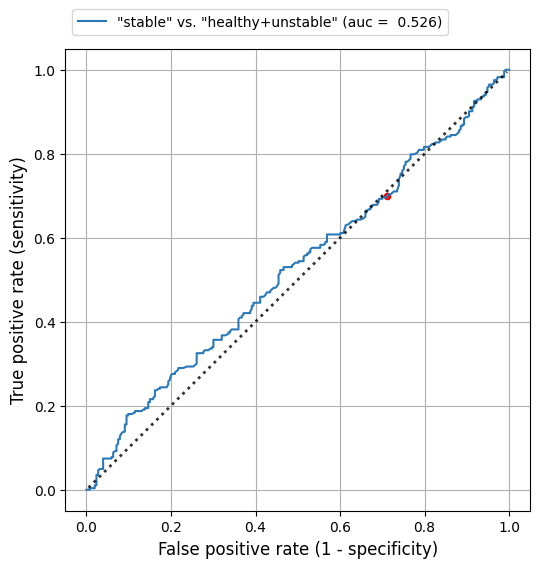

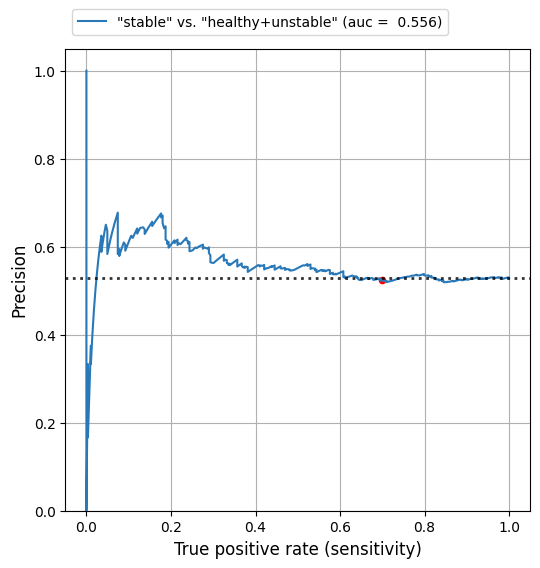

case                                              11
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                                stable
negative_class                      healthy_unstable
image_name             11_stable_vs_healthy_unstable
roc_auc                                        0.526
pr_auc                                         0.556
min_precision                                  0.528
max_f1_thresh                                  0.022
max_f1_score                                   0.693
TP                                               198
TN                                                73
FP                                               180
FN                                                85
n_actual_pos                                     283
n_actual_neg                                     253
n_pred_pos                                    

Case number: 12
Positive disease classes: stable
Negative disease classes: healthy+veryunstable


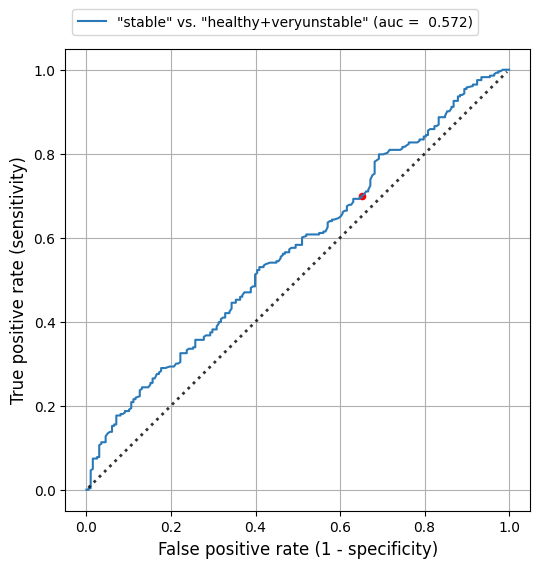

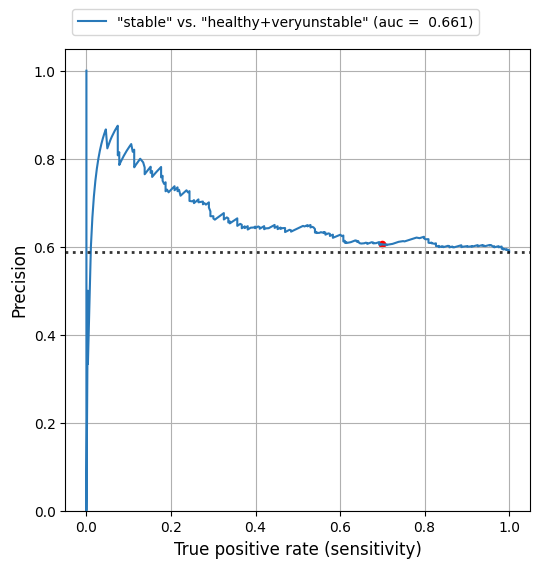

case                                              12
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                                stable
negative_class                  healthy_veryunstable
image_name         12_stable_vs_healthy_veryunstable
roc_auc                                        0.572
pr_auc                                         0.661
min_precision                                  0.588
max_f1_thresh                                  0.066
max_f1_score                                   0.745
TP                                               198
TN                                                69
FP                                               129
FN                                                85
n_actual_pos                                     283
n_actual_neg                                     198
n_pred_pos                                    

Case number: 13
Positive disease classes: stable
Negative disease classes: unstable+veryunstable


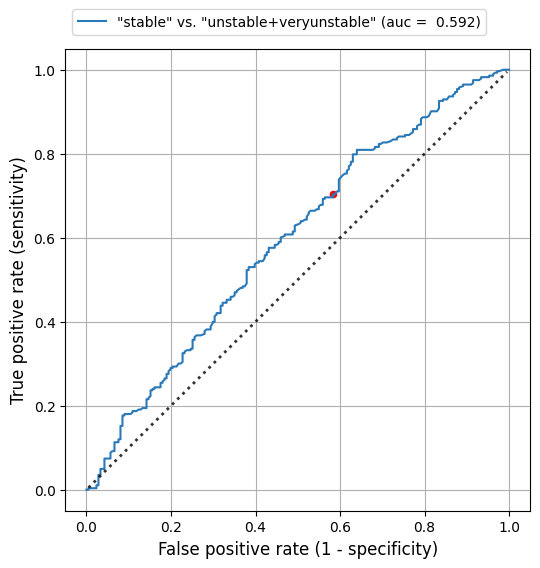

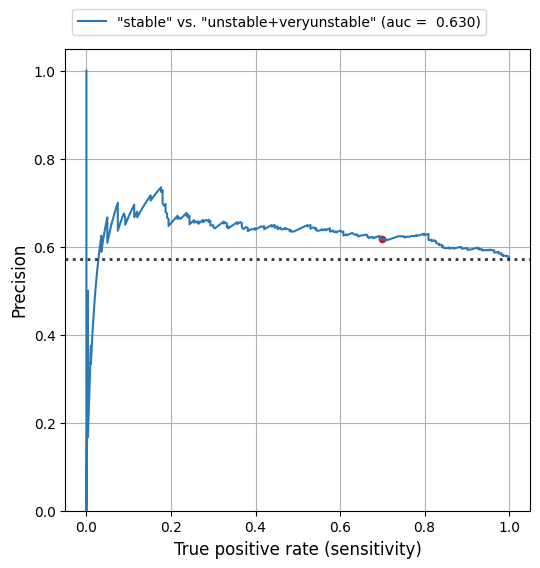

case                                              13
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                                stable
negative_class                 unstable_veryunstable
image_name        13_stable_vs_unstable_veryunstable
roc_auc                                        0.592
pr_auc                                          0.63
min_precision                                  0.573
max_f1_thresh                                  0.079
max_f1_score                                   0.734
TP                                               199
TN                                                88
FP                                               123
FN                                                84
n_actual_pos                                     283
n_actual_neg                                     211
n_pred_pos                                    

Case number: 14
Positive disease classes: stable
Negative disease classes: healthy+unstable+veryunstable


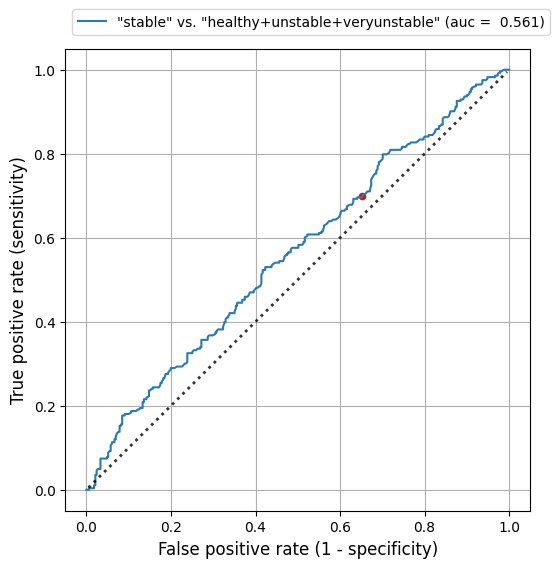

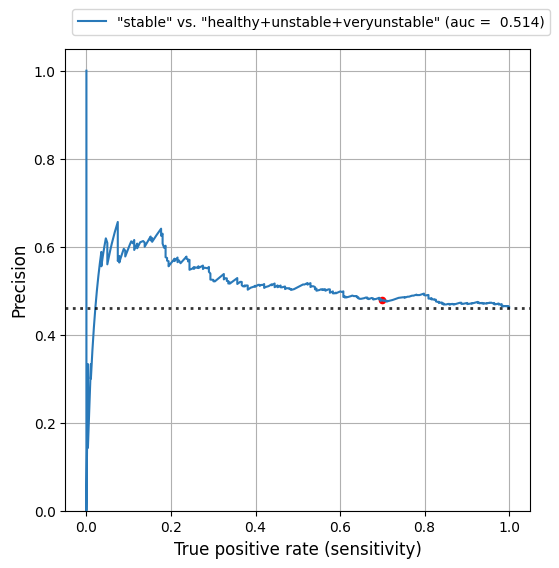

case                                                      14
model                                           periocl3_128
version                                                    1
testdata                  periodata_240415_split_ide.parquet
positive_class                                        stable
negative_class                 healthy_unstable_veryunstable
image_name        14_stable_vs_healthy_unstable_veryunstable
roc_auc                                                0.561
pr_auc                                                 0.514
min_precision                                          0.461
max_f1_thresh                                          0.066
max_f1_score                                           0.635
TP                                                       198
TN                                                       115
FP                                                       216
FN                                                        85
n_actual_pos            

Case number: 15
Positive disease classes: unstable
Negative disease classes: healthy


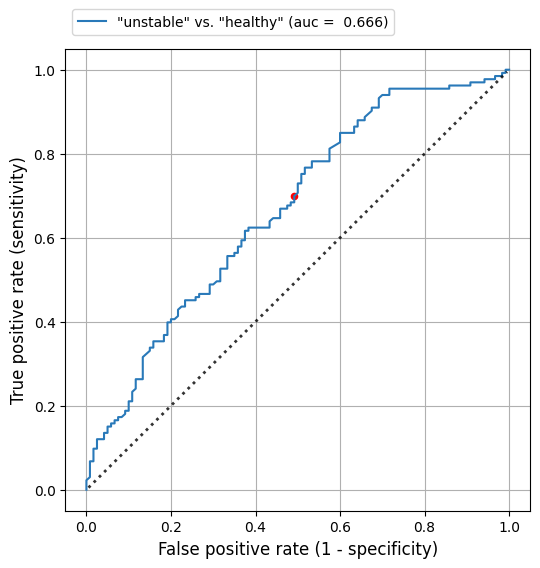

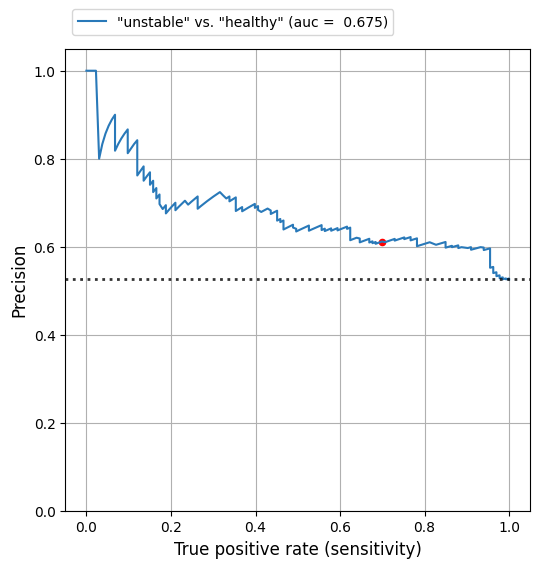

case                                              15
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                              unstable
negative_class                               healthy
image_name                    15_unstable_vs_healthy
roc_auc                                        0.666
pr_auc                                         0.675
min_precision                                  0.526
max_f1_thresh                                  0.128
max_f1_score                                   0.734
TP                                                93
TN                                                61
FP                                                59
FN                                                40
n_actual_pos                                     133
n_actual_neg                                     120
n_pred_pos                                    

Case number: 16
Positive disease classes: unstable
Negative disease classes: stable


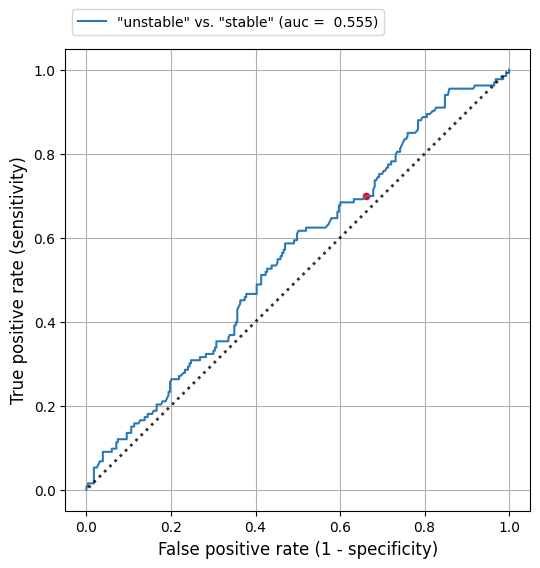

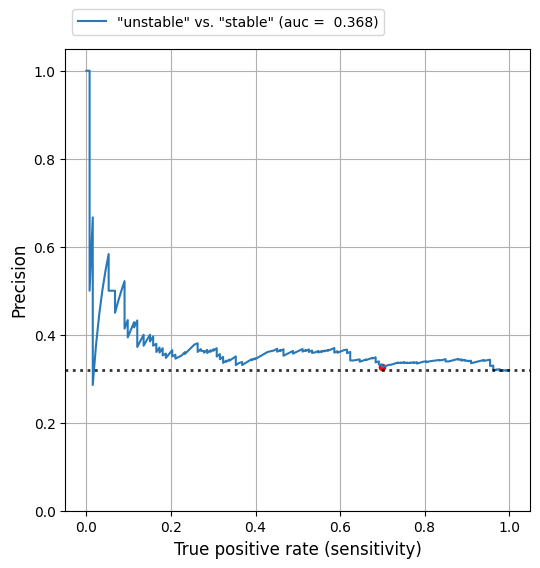

case                                              16
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                              unstable
negative_class                                stable
image_name                     16_unstable_vs_stable
roc_auc                                        0.555
pr_auc                                         0.368
min_precision                                   0.32
max_f1_thresh                                  0.128
max_f1_score                                   0.505
TP                                                93
TN                                                96
FP                                               187
FN                                                40
n_actual_pos                                     133
n_actual_neg                                     283
n_pred_pos                                    

Case number: 17
Positive disease classes: unstable
Negative disease classes: healthy+stable


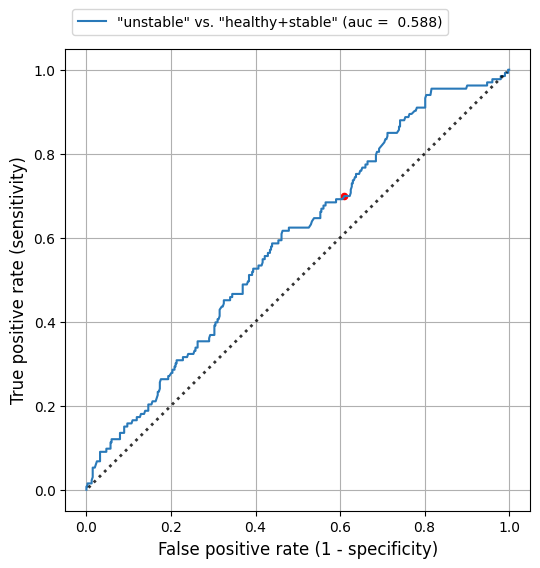

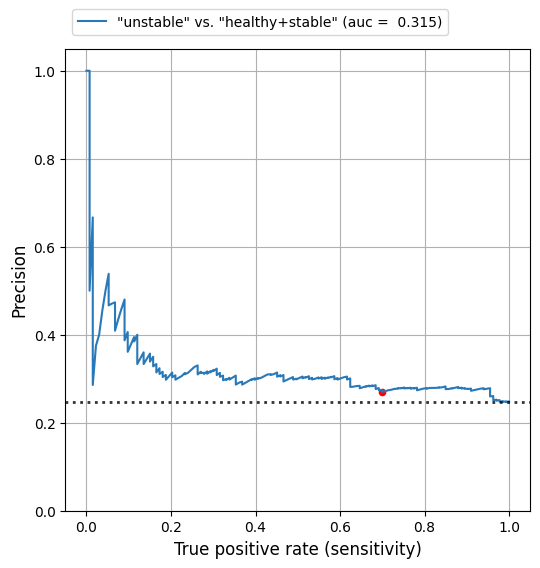

case                                              17
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                              unstable
negative_class                        healthy_stable
image_name             17_unstable_vs_healthy_stable
roc_auc                                        0.588
pr_auc                                         0.315
min_precision                                  0.248
max_f1_thresh                                  0.128
max_f1_score                                   0.431
TP                                                93
TN                                               157
FP                                               246
FN                                                40
n_actual_pos                                     133
n_actual_neg                                     403
n_pred_pos                                    

Case number: 18
Positive disease classes: veryunstable
Negative disease classes: healthy


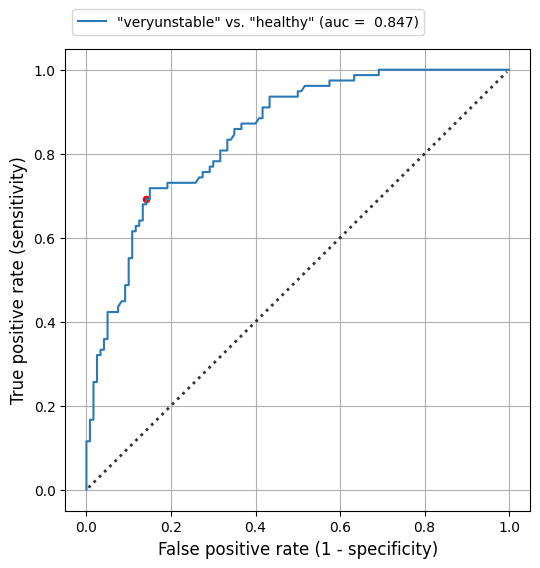

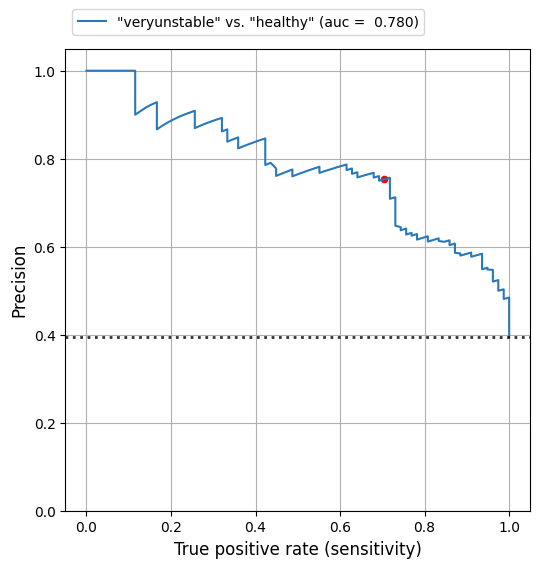

case                                              18
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                          veryunstable
negative_class                               healthy
image_name                18_veryunstable_vs_healthy
roc_auc                                        0.847
pr_auc                                          0.78
min_precision                                  0.394
max_f1_thresh                                  0.543
max_f1_score                                   0.737
TP                                                54
TN                                               103
FP                                                17
FN                                                24
n_actual_pos                                      78
n_actual_neg                                     120
n_pred_pos                                    

Case number: 19
Positive disease classes: veryunstable
Negative disease classes: stable


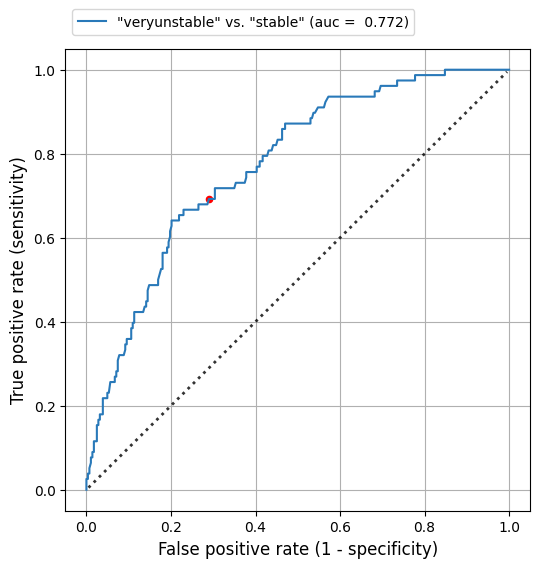

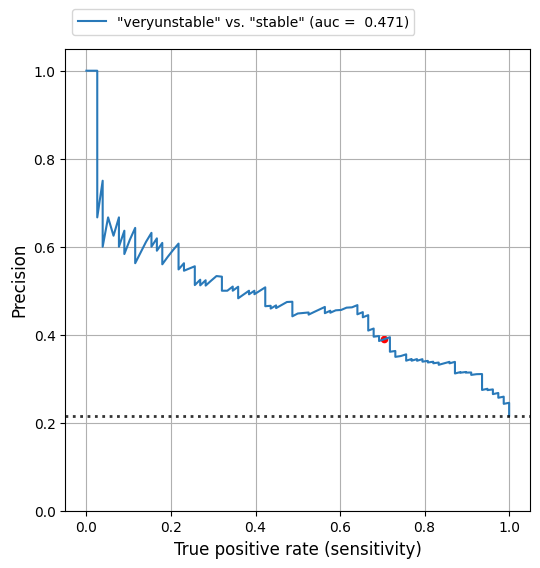

case                                              19
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                          veryunstable
negative_class                                stable
image_name                 19_veryunstable_vs_stable
roc_auc                                        0.772
pr_auc                                         0.471
min_precision                                  0.216
max_f1_thresh                                  0.633
max_f1_score                                   0.541
TP                                                54
TN                                               201
FP                                                82
FN                                                24
n_actual_pos                                      78
n_actual_neg                                     283
n_pred_pos                                    

Case number: 20
Positive disease classes: veryunstable
Negative disease classes: healthy+stable


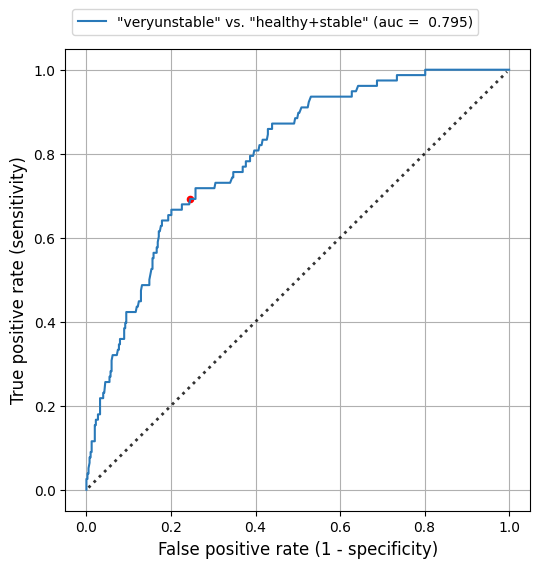

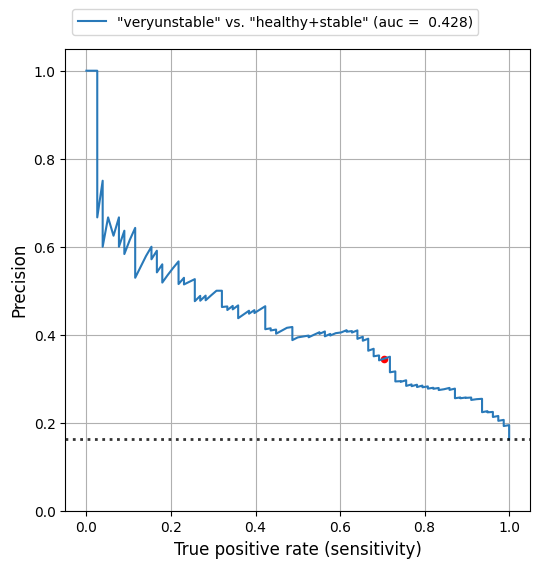

case                                              20
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                          veryunstable
negative_class                        healthy_stable
image_name         20_veryunstable_vs_healthy_stable
roc_auc                                        0.795
pr_auc                                         0.428
min_precision                                  0.162
max_f1_thresh                                  0.633
max_f1_score                                     0.5
TP                                                54
TN                                               304
FP                                                99
FN                                                24
n_actual_pos                                      78
n_actual_neg                                     403
n_pred_pos                                    

Case number: 21
Positive disease classes: unstable+veryunstable
Negative disease classes: healthy


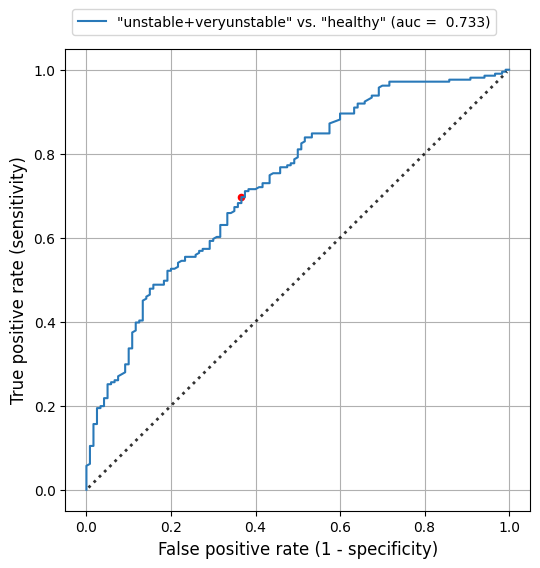

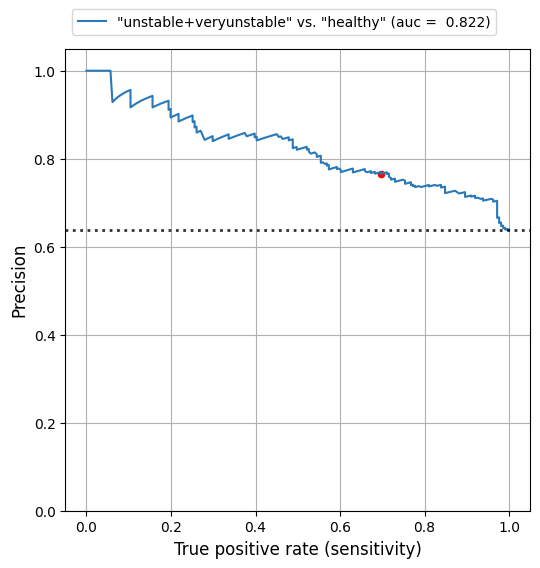

case                                               21
model                                    periocl3_128
version                                             1
testdata           periodata_240415_split_ide.parquet
positive_class                  unstable_veryunstable
negative_class                                healthy
image_name        21_unstable_veryunstable_vs_healthy
roc_auc                                         0.733
pr_auc                                          0.822
min_precision                                   0.637
max_f1_thresh                                   0.128
max_f1_score                                    0.817
TP                                                147
TN                                                 76
FP                                                 44
FN                                                 64
n_actual_pos                                      211
n_actual_neg                                      120
n_pred_pos                  

Case number: 22
Positive disease classes: unstable+veryunstable
Negative disease classes: stable


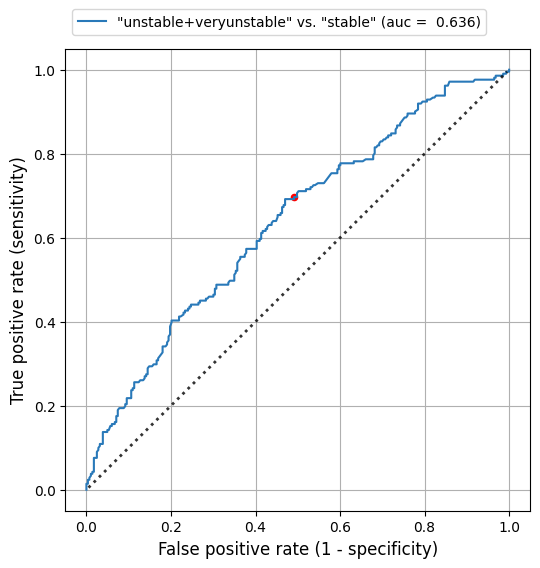

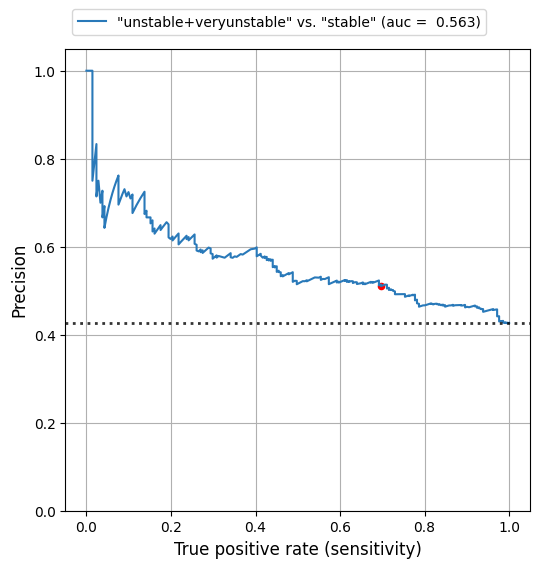

case                                              22
model                                   periocl3_128
version                                            1
testdata          periodata_240415_split_ide.parquet
positive_class                 unstable_veryunstable
negative_class                                stable
image_name        22_unstable_veryunstable_vs_stable
roc_auc                                        0.636
pr_auc                                         0.563
min_precision                                  0.427
max_f1_thresh                                  0.128
max_f1_score                                   0.622
TP                                               147
TN                                               144
FP                                               139
FN                                                64
n_actual_pos                                     211
n_actual_neg                                     283
n_pred_pos                                    

Case number: 23
Positive disease classes: unstable+veryunstable
Negative disease classes: healthy+stable


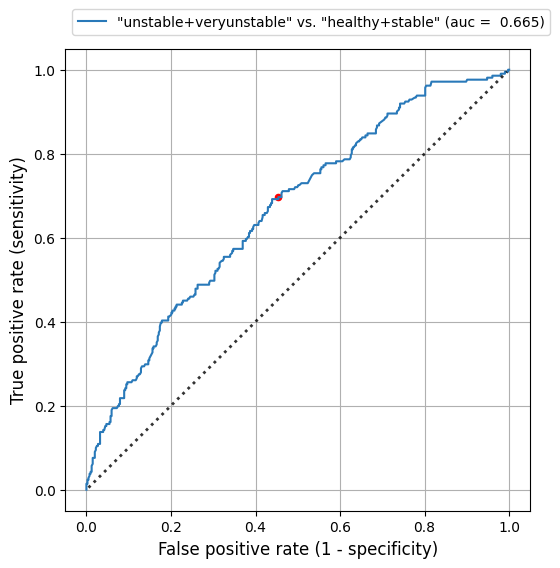

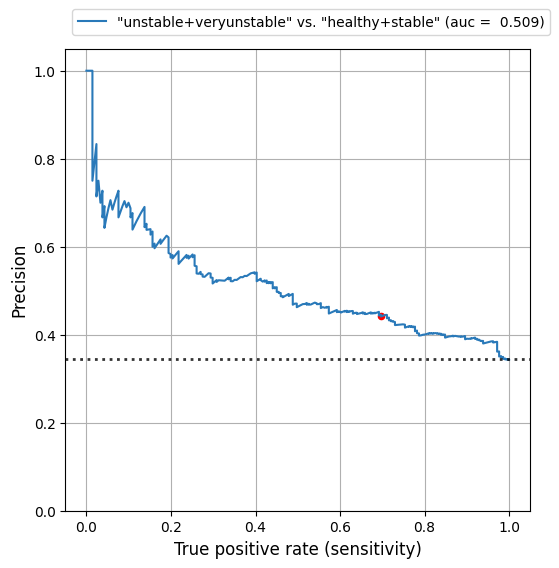

case                                                      23
model                                           periocl3_128
version                                                    1
testdata                  periodata_240415_split_ide.parquet
positive_class                         unstable_veryunstable
negative_class                                healthy_stable
image_name        23_unstable_veryunstable_vs_healthy_stable
roc_auc                                                0.665
pr_auc                                                 0.509
min_precision                                          0.344
max_f1_thresh                                          0.165
max_f1_score                                           0.551
TP                                                       147
TN                                                       220
FP                                                       183
FN                                                        64
n_actual_pos            

In [18]:
fig_output_dir = os.path.join(output_dir, 'performance', 'marked')
Path(fig_output_dir).mkdir(parents=True, exist_ok=True)
checkpoint = 1400
decimals = 3
disease_dict = label_dict.get(label_col)
sensitivity = 0.7

# Initialize a list to store the output metrics
case_metrics_df_list = []
case = 0
# pos_cl = 0
for pos_cl in disease_dict.keys():
    
    case_dict = disease_comparisons(positive_class=pos_cl, disease_dict=disease_dict)
    pos_cases = case_dict.get('positive_cases')
    neg_cases = case_dict.get('negative_cases')
        
        # Loop over all combinations of pos and neg cases
    # pos_disease_list = pos_cases[0]
    # neg_disease_list = neg_cases[0]
    
    for pos_disease_list in pos_cases:
        for neg_disease_list in neg_cases:
                
            case += 1
            
            pos_disease_str = join_str_list(pos_disease_list, sep='+')
            pos_name = join_str_list(pos_disease_list)
            
            neg_disease_str = join_str_list(neg_disease_list, sep='+')
            neg_name = join_str_list(neg_disease_list)
            
            # Set the ground truth
            pos_cl_dict = {disease: 1 for disease in pos_disease_list}
            neg_cl_dict = {disease: 0 for disease in neg_disease_list}
            print(f'Case number: {case}')
            print(f'Positive disease classes: {pos_disease_str}')
            print(f'Negative disease classes: {neg_disease_str}')
            cl_dict = pos_cl_dict.copy()
            cl_dict.update(neg_cl_dict)
            disease_list = list(cl_dict.keys())
            
            # Set the file name for the figures
            basename = f'{case}_{pos_name}_vs_{neg_name}'
            
            # Filter testset for the disease classes that we want to compare
            # Filter the checkpoint
            test_pred = pred.loc[(pred.get('disease').isin(disease_list)) & (pred.get('epoch') == checkpoint)]
            # Set the positive and negative disease classes for binary comparisons
            test_pred = test_pred.assign(true=test_pred['disease'].apply(lambda d: cl_dict.get(d)))
            test_pred_stat = patient_image_stat(data=test_pred, file_col='file', group_col='true')
            
            # Ground truth values and model output for this test case
            y_true = test_pred.get('true').values
            y_pred = list(test_pred.get(f'prob_{pos_cl}').round(decimals=decimals).values)
            
            # Calculate the performance metrics
            metrics_dict, roc_dict = performance_metrics(y_true=y_true, 
                                                         y_pred=y_pred,
                                                         test_pred_stat=test_pred_stat,
                                                         sensitivity=sensitivity)
            
            fpr = roc_dict.get('fpr')
            tpr = roc_dict.get('tpr')
            roc_auc = metrics_dict.get('roc_auc')
            pre = roc_dict.get('pre')
            rec = roc_dict.get('rec')
            pr_auc = metrics_dict.get('pr_auc')
            min_precision = metrics_dict.get('min_precision')
            
            # Create the ROC and PR curves
            color = colors[4]
            label_base = f'"{pos_disease_str}" vs. "{neg_disease_str}"'
            
            fig, ax = plt.subplots(figsize=figsize)
            label_roc = f'{label_base} (auc = {roc_auc: .3f})'
            roc_file_name = f'roc_{basename}.png'
            roc_file = os.path.join(fig_output_dir, roc_file_name)
            ax = plot_roc(fpr=fpr, tpr=tpr, label=label_roc, ax=ax, color=color)
            ax.scatter(x=metrics_dict.get('FPR'), y=metrics_dict.get('TPR'), color='r', marker='o', s=20)
            plt.savefig(roc_file, bbox_inches='tight')
            plt.show()
            
            fig, ax = plt.subplots(figsize=figsize)
            label_pre = f'{label_base} (auc = {pr_auc: .3f})'
            pre_file_name = f'pr_{basename}.png'
            pre_file = os.path.join(fig_output_dir, pre_file_name)
            ax = plot_pr(rec=rec, pre=pre, ns_pre=min_precision, label=label_pre, ax=ax, color=color)
            ax.scatter(x=metrics_dict.get('recall'), y=metrics_dict.get('precision'), color='r', marker='o', s=20)
            plt.savefig(pre_file, bbox_inches='tight')
            plt.show()
            
            # Save the performance calculations for this case
            performance_dict = {'case': case,
                                'model': model_name,
                                'version': model_version_number,
                                'testdata': patient_split_data_file,
                                'positive_class': pos_name,
                                'negative_class': neg_name,
                                'image_name': basename}
            performance_dict.update(metrics_dict)
            case_df = pd.DataFrame(performance_dict, index=[0])
            case_metrics_df_list.append(case_df)
            print()
            display(case_df.iloc[0])

case_metrics_df = pd.concat(case_metrics_df_list, axis=0, ignore_index=True).\
                sort_values(by='case', ascending=True).\
                reset_index(drop=True)

In [19]:
# Performance data output file
performance_metrics_name = 'performance_periodata0415'
performance_metrics_parquet = f'{performance_metrics_name}.parquet'
performance_metrics_csv = f'{performance_metrics_name}.csv'

performance_metrics_parquet_file = os.path.join(output_dir, performance_metrics_parquet)
performance_metrics_csv_file = os.path.join(output_dir, performance_metrics_csv)

case_metrics_df.to_parquet(performance_metrics_parquet_file)
case_metrics_df.to_csv(performance_metrics_csv_file, index=False)

In [20]:
print(performance_metrics_csv_file)

/app/data/model_trained/periotrain_240428/periocl3_128/version_1/output/performance_periodata0415.csv
